In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [2]:
!pip install seaborn


In [7]:
plt.style.use('seaborn-v0_8')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

class Gaussian_Wave:
    def __init__(self, N_grid, L, a, V0, w, x0, k0, sigma, t):
        """
        N_grid : int      -> number of grid intervals (will produce N_grid+1 grid points)
        L      : float    -> domain length [0, L]
        a,w    : floats   -> potential-barrier start and width
        V0     : float    -> barrier height
        x0     : float    -> initial gaussian center
        k0     : float    -> initial momentum
        sigma  : float    -> gaussian width
        t      : array-like of times at which to animate
        """
        self.t = t
        self.L = L
        self.N_grid = N_grid

        self.x = np.linspace(0, self.L, self.N_grid + 1)  # grid of points
        self.dx = self.x[1] - self.x[0]

        def integral(f, axis=0):
            """Approximate integral in discrete space using simple Riemann sum"""
            return np.sum(f * self.dx, axis=axis)

        # initial wavefunction on interior points (zero at endpoints)
        self.Psi0 = np.exp(-0.5 * (self.x[1:-1] - x0) ** 2 / sigma ** 2) * np.exp(1j * k0 * self.x[1:-1])

        # normalize initial state
        norm = integral(np.abs(self.Psi0) ** 2)
        self.Psi0 = self.Psi0 / np.sqrt(norm)

        # kinetic energy operator (finite difference, interior points)
        size = self.N_grid - 1
        main = -2 * np.ones(size)
        off = np.ones(size - 1)
        self.T = -0.5 * (1 / self.dx ** 2) * (np.diag(main) + np.diag(off, 1) + np.diag(off, -1))
        # print(self.T.shape)  # optional check

        # potential (flat array on interior points)
        self.V_flat = np.array([V0 if a < pos < a + w else -0.01 for pos in self.x[1:-1]])
        self.V = np.diag(self.V_flat)

        # Hamiltonian
        self.H = self.T + self.V

    def animation(self):
        """Compute eigen-decomposition and return a FuncAnimation for the time evolution."""
        def integral(f, axis=0):
            return np.sum(f * self.dx, axis=axis)

        # eigen-decomposition
        E, psi = np.linalg.eigh(self.H)  # psi.shape -> (N-1, N-1) columns are eigenvectors
        psi = psi.T  # now psi[j] is eigenvector j as a 1D array

        # normalize eigenvectors (just in case)
        norm = integral(np.abs(psi) ** 2)
        psi = psi / np.sqrt(norm[:, None])  # shape-correct normalization

        # expansion coefficients c_n = <psi_n | Psi0>
        c_n = np.zeros(psi.shape[0], dtype=complex)
        for j in range(psi.shape[0]):
            c_n[j] = integral(np.conj(psi[j]) * self.Psi0)

        # time-dependent wavefunction on interior points
        def Psi(t):
            return psi.T @ (c_n * np.exp(-1j * E * t))

        # plotting setup
        fig = plt.figure(figsize=(10, 6))
        ax = plt.axes(xlim=(0, self.L), ylim=(-0.6, 0.6))
        ax.plot(self.x[1:-1], self.V_flat, label=r'$V(x)$')
        ax.set_title('Gaussian wave packet with a potential barrier', fontsize=14)
        line1, = ax.plot(self.x[1:-1], np.zeros(self.N_grid - 1), lw=2, label=r'$\Re(\psi)$')
        line2, = ax.plot(self.x[1:-1], np.zeros(self.N_grid - 1), lw=2, label=r'$\Im(\psi)$')
        ax.legend(fontsize=12)
        ax.set_xlabel(r'$x$', fontsize=12)

        def animate(frame_idx):
            tval = self.t[frame_idx]
            y = Psi(tval)
            y1 = np.real(y)
            y2 = np.imag(y)
            line1.set_data(self.x[1:-1], y1)
            line2.set_data(self.x[1:-1], y2)
            return (line1, line2)

        def init():
            line1.set_data([], [])
            line2.set_data([], [])
            return (line1, line2)

        # frames can be integer (number of frames) or an iterable; passing len(self.t)
        ani = FuncAnimation(fig, animate, frames=len(self.t), init_func=init,
                            interval=20, blit=False)  # set blit=True if you want faster updates (works in many cases)

        return ani


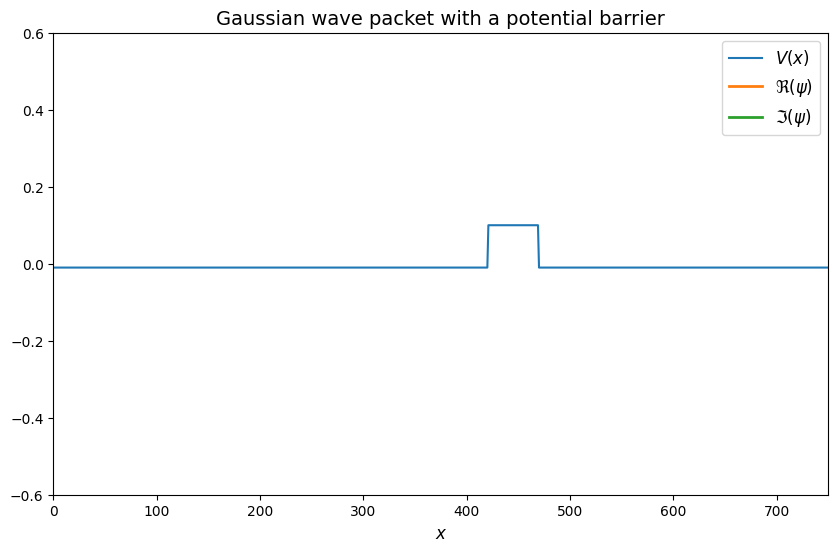

In [4]:
wavepacket = Gaussian_Wave(750,750, 420,0.1,50,100,0.4,15, np.linspace(0.,2500,1000))
Psi = wavepacket.animation()
HTML(Psi.to_html5_video())